In [1]:
!wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_Input.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2019/ISIC_2019_Training_GroundTruth.csv

In [2]:
!unzip "./ISIC_2019_Training_Input.zip"

In [3]:
import os
import glob
import tempfile
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [4]:
directory = "/content/drive/MyDrive/Colab Notebooks/ELEC4840/Project/2019/"

root_dir = tempfile.mkdtemp() if directory is None else directory
os.chdir(root_dir)
os.listdir('.')

['ISIC_2019_Training_Input',
 'ISIC_2019_Training_GroundTruth.csv',
 'train',
 'val',
 'test',
 '2019_InceptionV3.ipynb']

In [5]:
# import os

# if not os.path.exists("./train"):
#     os.makedirs("./train")
#     os.makedirs("./train/benign")
#     os.makedirs("./train/malignant")

# if not os.path.exists("./val"):
#     os.makedirs("./val")
#     os.makedirs("./val/benign")
#     os.makedirs("./val/malignant")

# if not os.path.exists("./test"):
#     os.makedirs("./test")
#     os.makedirs("./test/benign")
#     os.makedirs("./test/malignant")

In [6]:
# print(os.path.exists('./train'))
# print(os.path.exists('./val'))
# print(os.path.exists('./test'))

In [7]:
# import shutil
# import os
# import pandas as pd
# import numpy as np

# df = pd.read_csv("./ISIC_2019_Training_GroundTruth.csv")
# img_lis = []
# lbl_lis = []

# for i in range(len(df)):
#     name = df["image"][i]
#     label_mel, label_nv, label_bcc, label_akiec, label_bkl, label_df, label_vasc, label_scc, label_unk = (
#         df["MEL"][i],
#         df["NV"][i],
#         df["BCC"][i],
#         df["AK"][i],
#         df["BKL"][i],
#         df["DF"][i],
#         df["VASC"][i],
#         df["SCC"][i],
#         df["UNK"][i]
#     )

#     label = "benign" if label_mel == 0 and label_bcc == 0 and label_akiec == 0 and label_scc == 0 else "malignant"

#     img_lis.append(name)
#     lbl_lis.append(label)

# N_train_val = len(img_lis)
# N_train = int(N_train_val * 0.6)
# N_val = int(N_train_val * 0.2)
# print(N_train_val)
# print(N_train)
# print(N_val)

# shuffle_ix = np.random.permutation(np.arange(N_train_val))
# ix_train = shuffle_ix[:N_train]
# ix_val = shuffle_ix[N_train:N_train + N_val]
# ix_test = shuffle_ix[N_train + N_val:]

# for i in ix_train:
#     name, label = img_lis[i], lbl_lis[i]
#     src_path = "./ISIC_2019_Training_Input/" + name + ".jpg"
#     dest_path = "./train/" + label + "/" + name + ".jpg"
#     if os.path.exists(src_path):
#         shutil.copy(src_path, dest_path)

# for i in ix_val:
#     name, label = img_lis[i], lbl_lis[i]
#     src_path = "./ISIC_2019_Training_Input/" + name + ".jpg"
#     dest_path = "./val/" + label + "/" + name + ".jpg"
#     if os.path.exists(src_path):
#         shutil.copy(src_path, dest_path)

# for i in ix_test:
#     name, label = img_lis[i], lbl_lis[i]
#     src_path = "./ISIC_2019_Training_Input/" + name + ".jpg"
#     dest_path = "./test/" + label + "/" + name + ".jpg"
#     if os.path.exists(src_path):
#         shutil.copy(src_path, dest_path)

In [8]:
# def count_files(directory):
#     count = 0
#     for root, dirs, files in os.walk(directory):
#         count += len(files)
#     return count

# train_files = count_files('./train')
# val_files = count_files('./val')
# test_files = count_files('./test')

# print("Number of files in 'train':", train_files)
# print("Number of files in 'val':", val_files)
# print("Number of files in 'test':", test_files)

In [16]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torch

def label_statistics(train_dataset):
    cls_count = np.zeros(2).astype(np.int64)

    for i, label in train_dataset:
        cls_count[label] += 1
    return cls_count

def label_weights_for_balance(train_dataset):
    cls_count = label_statistics(train_dataset)
    labels_weight_list = []
    for i, label in train_dataset:
        weight = 1 / cls_count[label]
        labels_weight_list.append(weight)
    return labels_weight_list

root_train, root_val, root_test = './train', './val', './test'

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomVerticalFlip(),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.5, contrast=1, saturation=0.1, hue=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


def get_train_test_set():
    train_dataset = ImageFolder(root_train, transform=train_transform)
    val_dataset = ImageFolder(root_val, transform=test_transform)
    test_dataset = ImageFolder(root_test, transform=test_transform)

    # train_dataset = torch.utils.data.Subset(train_dataset, range(8000))
    # val_dataset = torch.utils.data.Subset(val_dataset, range(2000))
    # test_dataset = torch.utils.data.Subset(test_dataset, range(2000))

    loader_train = torch.utils.data.DataLoader(
        dataset=train_dataset,
        batch_size=128,
        shuffle=True
    )

    loader_val = torch.utils.data.DataLoader(
        dataset=val_dataset,
        batch_size=64,
        shuffle=False
    )

    loader_test = torch.utils.data.DataLoader(
        dataset=test_dataset,
        batch_size=64,
        shuffle=False
    )

    return loader_train, loader_val, loader_test

loader_train, loader_val, loader_test = get_train_test_set()

In [17]:
len(loader_train)

119

In [18]:
# import torch.nn as nn
# import torch

# class MyEnsemble(nn.Module):

#     def __init__(self, modelA, modelB, modelC, input):
#         super(MyEnsemble, self).__init__()
#         self.modelA = modelA
#         self.modelB = modelB
#         self.modelC = modelC

#         self.fc1 = nn.Linear(input, 16)

#     def forward(self, x):
#         out1 = self.modelA(x)
#         out2 = self.modelB(x)
#         out3 = self.modelC(x)

#         out = out1 + out2 + out3

#         x = self.fc1(out)
#         return torch.softmax(x, dim=1)

In [19]:
# resnet = model.load_state_dict(torch.load("resnet_model.pth"))
# alexnet = model.load_state_dict(torch.load("alexnet_model.pth"))
# vgg16 = model.load_state_dict(torch.load("vgg16_model.pth"))

# model = MyEnsemble(resnet, alexnet, vgg16)

In [20]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import resnet50

class Bottleneck(nn.Module):
    expansion = 4
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv3(out)
        out = self.bn3(out)
        if self.downsample is not None:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, use_fc=False, dropout=None):
        self.inplanes = 64
        super(ResNet, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AvgPool2d(7, stride=1)

        self.use_fc = use_fc
        self.use_dropout = True if dropout else False
        if self.use_fc:
            print('Using fc.')
            self.fc_add = nn.Linear(512*block.expansion, 512)
        if self.use_dropout:
            print('Using dropout.')
            self.dropout = nn.Dropout(p=dropout)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
        return nn.Sequential(*layers)

    def forward(self, x, *args):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = x.mean(dim=(-2, -1))
        x = x.view(x.size(0), -1)
        if self.use_fc:
            x = F.relu(self.fc_add(x))
        if self.use_dropout:
            x = self.dropout(x)
        return x

def get_resnet50(pre_trained=True):
    Resnet50 = ResNet(Bottleneck, [3, 4, 6, 3], dropout=None)
    if pre_trained:
        pre_trained = resnet50(weights = "IMAGENET1K_V2").state_dict()
        new_weights = {k: pre_trained[k] for k in Resnet50.state_dict()}
        Resnet50.load_state_dict(new_weights)
    return Resnet50

In [21]:
class ClassificationModel(nn.Module):
    def __init__(self, encoder, num_classes=1):
        super(ClassificationModel, self).__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        x = self.classifier(x)
        return x

resnet50 = get_resnet50(pre_trained=True)
model = ClassificationModel(resnet50, 2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ClassificationModel(
  (encoder): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

In [22]:
from tqdm import tqdm
import numpy as np
import torch.nn as nn
from sklearn.metrics import roc_auc_score, accuracy_score
from torchvision.ops import focal_loss

max_epoch = 20
use_cuda = torch.cuda.is_available()
if use_cuda:
    model = model.cuda()

criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

loss_list, val_loss_list = [], []
auc_train_list, acc_train_list = [], []
auc_val_list, acc_val_list = [], []

for epoch in range(max_epoch):
    print(" -- Epoch {}/{}".format(epoch + 1, max_epoch))

    model.train()
    running_loss = 0.0
    train_lbl = []
    train_pred = []
    for data in tqdm(loader_train):
        optimizer.zero_grad()
        images, labels = data
        labels = labels.float()
        if use_cuda:
            images = images.cuda()
            labels = labels.float().cuda()
        outputs = model(images)[:,0]
        outputs = torch.sigmoid(outputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        y_scores = list(outputs.detach().cpu().numpy())
        y_true = list(labels.detach().cpu().numpy())
        train_lbl += y_true
        train_pred += y_scores

    loss = running_loss / len(loader_train)
    loss_list.append(loss)
    train_lbl, train_pred = np.array(train_lbl), np.array(train_pred)
    train_pred_lbl = np.around(train_pred)
    train_auc = roc_auc_score(train_lbl, train_pred)
    train_acc = accuracy_score(train_lbl, train_pred_lbl)
    auc_train_list.append(train_auc)
    acc_train_list.append(train_acc)


    model.eval()
    test_lbl, test_pred = [], []
    val_loss = 0.0
    for data in loader_val:
        test_images, test_labels = data
        test_labels = test_labels.float()
        if use_cuda:
            test_images = test_images.cuda()
            test_labels = test_labels.float().cuda()
        with torch.no_grad():
            test_outputs = model(test_images)[:, 0]
        test_outputs = torch.sigmoid(test_outputs)
        y_scores = list(test_outputs.detach().cpu().numpy())
        y_true = list(test_labels.detach().cpu().numpy())
        test_lbl += y_true
        test_pred += y_scores

        v_loss = criterion(test_outputs, test_labels)
        val_loss += v_loss.item()

    test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
    test_pred_lbl = np.around(test_pred)
    test_auc = roc_auc_score(test_lbl, test_pred)
    test_acc = accuracy_score(test_lbl, test_pred_lbl)
    auc_val_list.append(test_auc)
    acc_val_list.append(test_acc)
    val_loss = val_loss / len(loader_val)
    val_loss_list.append(val_loss)
    print(loss, val_loss, train_auc, test_auc)

torch.save(model.state_dict(), 'inception_model.pth')

model.eval()
test_lbl, test_pred = [], []
for data in loader_test:
    test_images, test_labels = data
    test_labels = test_labels.float()
    if use_cuda:
        test_images = test_images.cuda()
        test_labels = test_labels.float().cuda()
    test_outputs = model(test_images)[:, 0]
    test_outputs = torch.sigmoid(test_outputs)
    y_scores = list(test_outputs.detach().cpu().numpy())
    y_true = list(test_labels.detach().cpu().numpy())
    test_lbl += y_true
    test_pred += y_scores

test_lbl, test_pred = np.array(test_lbl), np.array(test_pred)
test_pred_lbl = np.around(test_pred)
test_auc = roc_auc_score(test_lbl, test_pred)
test_acc = accuracy_score(test_lbl, test_pred_lbl)
print(test_auc, test_acc)

 -- Epoch 1/20


100%|██████████| 119/119 [49:40<00:00, 25.05s/it]


0.5322219045723185 0.4655587252229452 0.784870528263892 0.8561214739314793
 -- Epoch 2/20


100%|██████████| 119/119 [05:57<00:00,  3.01s/it]


0.4671828080626095 0.44039967078715564 0.8437672869322681 0.8665936734815758
 -- Epoch 3/20


100%|██████████| 119/119 [05:56<00:00,  3.00s/it]


0.44712136898721966 0.41763286404311656 0.8583211917037114 0.8818616911857411
 -- Epoch 4/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.4318682819354434 0.41474372893571854 0.868223772468399 0.8826546626055912
 -- Epoch 5/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.4131625795564732 0.4162208054214716 0.8805646229146955 0.8894987690694697
 -- Epoch 6/20


100%|██████████| 119/119 [05:56<00:00,  3.00s/it]


0.405805302267315 0.4147456182166934 0.8855569651628112 0.896299660249902
 -- Epoch 7/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.3911892418600932 0.3833809821866453 0.8935276137327739 0.9028483931545663
 -- Epoch 8/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.37864550372131733 0.38005839865654706 0.9009049535326326 0.9016440056005679
 -- Epoch 9/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.3681484515927419 0.37364750150591136 0.9065584886784579 0.9073104333804471
 -- Epoch 10/20


100%|██████████| 119/119 [05:55<00:00,  2.99s/it]


0.35820817646860076 0.37529291342943905 0.9122259724896443 0.9061624496512917
 -- Epoch 11/20


100%|██████████| 119/119 [05:55<00:00,  2.99s/it]


0.3452353210759764 0.3698099521454424 0.9180333446909539 0.9114909521629206
 -- Epoch 12/20


100%|██████████| 119/119 [05:56<00:00,  3.00s/it]


0.3363328881624366 0.37008708650246264 0.922742472041708 0.9095081918260904
 -- Epoch 13/20


100%|██████████| 119/119 [05:58<00:00,  3.01s/it]


0.3199957794502002 0.3895302936434746 0.93036628186226 0.9088812799023218
 -- Epoch 14/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.31596376427582334 0.3591578326188028 0.9323360707160896 0.9174206530899341
 -- Epoch 15/20


100%|██████████| 119/119 [05:56<00:00,  3.00s/it]


0.3034646643810913 0.36923830285668374 0.9377149115156651 0.9160055806607874
 -- Epoch 16/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.2950276206521427 0.3898199455812573 0.9411366975745298 0.9079944127034686
 -- Epoch 17/20


100%|██████████| 119/119 [05:56<00:00,  2.99s/it]


0.27953336857447103 0.3699682384729385 0.9473719098170668 0.9166526486572573
 -- Epoch 18/20


100%|██████████| 119/119 [05:56<00:00,  3.00s/it]


0.2730742466299474 0.4441172498976812 0.9499322326562641 0.9180339617382997
 -- Epoch 19/20


100%|██████████| 119/119 [05:57<00:00,  3.00s/it]


0.26434360131496143 0.3840406786184758 0.9528084138199976 0.9163257553135721
 -- Epoch 20/20


100%|██████████| 119/119 [05:57<00:00,  3.01s/it]


0.24913649148299916 0.39563174373470245 0.9584586323039319 0.9116072435782585
0.9059691767238937 0.8348134991119005


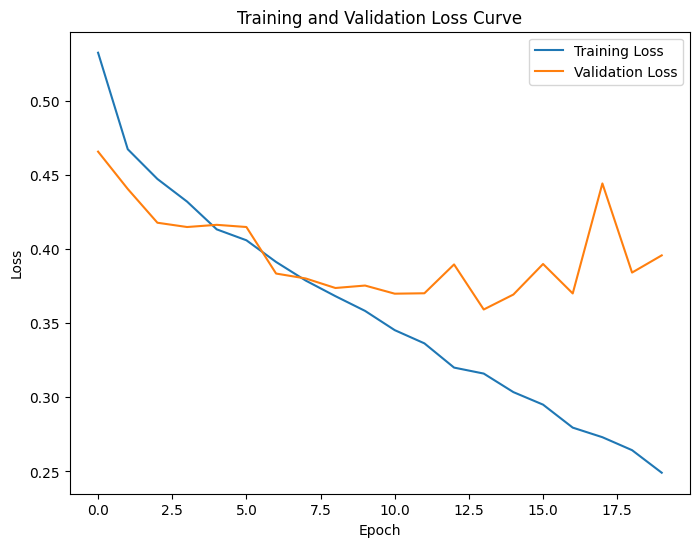

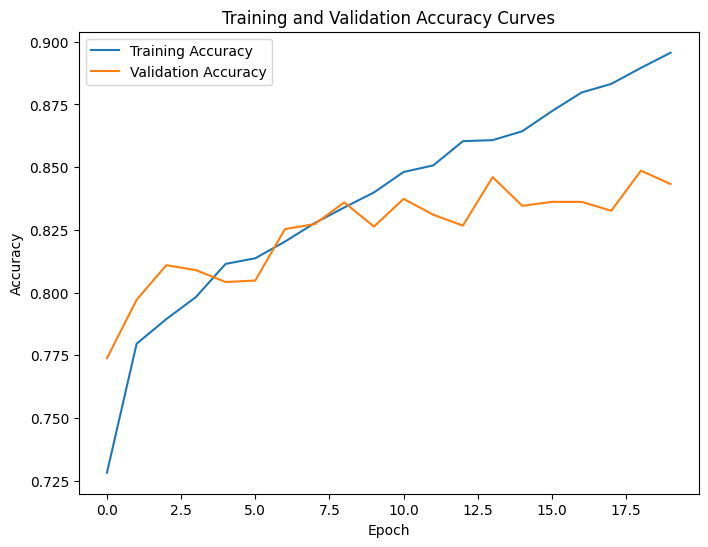

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curve')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.plot(acc_train_list, label='Training Accuracy')
plt.plot(acc_val_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Curves')
plt.legend()
plt.show()